Example 3: Clustering RdRps
=============================

In [1]:
import numpy as np
import itertools as it
import multiprocess
import matplotlib.pyplot as plt
import time
import os
from umap.umap_ import UMAP

from GWProt.GW_protein import *
from GWProt.GW_protein_pI import *

/home/jovyan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Riboviruses are a realm of viruses which include many human pathogens. They all have an essential RNA-dependent RNA-polymerase (RdRp) which is key to their replication machinery, has a high mutation rate, and often very low sequence homology; thus structural comparison can be key to identification and classification. In our benchmarking of GWProt, we used a dataset of 4,615 computationally determined (AlphaFold3) structures of viral RNA-dependent RNA polymerases (RdRp) as well as 512 non-RdRp “decoy” proteins, which were selected as non-viral homologs. For our testing we used taxonomical annotations retrieved from Entrez, with 5 phyla of riboviruses.

Here we display a UMAP clustering of the different phyla and decoys:


![Example_Data/Images/GW_Phylum_Clustering.PNG](Example_Data/Images/GW_Phylum_Clustering.PNG)

In this tutorial we use a subset consisting of 50 randomly chosen RdRps from the phyla Lenaviricota and Duplornaviricota.
We will run different variants of Gromov-Wasserstein which can be computed with GWProt to show their differences in clustering accuracy and runtime. All runtime is based on 16 parallel processes on a desktop computer. 

In [2]:
lenas = [os.path.join("Example_Data/RdRp Proteins/Lena_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Lena_RdRps")]
pisus = [os.path.join("Example_Data/RdRp Proteins/Pisu_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Pisu_RdRps")]

We define a helper method to compute pairwise all-vs-all GW distances, then display 
to compute the [silhoutte score](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.) and [Davies-Bouldin score](https://en.wikipedia.org/wiki/Davies–Bouldin_index), two basic measures of clustering to evaluate the accuracy of different methods in GWProt. A higher silhoutte score and lower Davies-Bouldin score mean better clustering.

In [3]:
from sklearn.metrics import silhouette_score # higher is better
from sklearn.metrics import davies_bouldin_score #lower is better

def display(dist_mat):
    N = dist_mat.shape[0]


    print(f"Silhouette Score: {silhouette_score(X = dist_mat, labels = [0 if i <(N//2) else 1 for i in range(N)], metric='precomputed')}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(dist_mat, labels = [0 if i <(N//2) else 1 for i in range(N)])}")
    
    reducer = UMAP(metric = 'precomputed', random_state=1)
    embedding = reducer.fit_transform(dist_mat)
    plt.figure(figsize=(4, 4))
    plt.scatter(embedding[:(N//2), 0], embedding[:(N//2), 1], c= ['red']*(N//2) , s=5)
    plt.scatter(embedding[(N//2):, 0], embedding[(N//2):, 1], c= ['blue']*(N//2) , s=5)
    plt.legend([ "Lena.", "Pisu."])
    plt.show()
    

In [4]:
def compute_in_parallel(proteins, comparison_method, returning = False, **kwargs):
    N = len(proteins)
    dist_mat = np.zeros((N,N))
    start_time = time.time()

    with multiprocess.Pool() as pool:
        for r in  pool.imap(lambda pair: (pair[0], pair[1], comparison_method(proteins[pair[0]], proteins[pair[1]], **kwargs)), it.combinations(range(N),2)):
            i,j,d = r
            dist_mat[i,j] = d
            dist_mat[j,i] = d

    run_time = int(time.time() - start_time)
    
    print(f'run time = {run_time//60} min, {run_time % 60} sec')
    display(dist_mat)
    if returning:
        return dist_mat
    

The main class in GWProt is `GW_protein`, whose objects contain the relevant data for a protein including the coordinates of each alpha-Carbon, the sequence, and the intra-protein distance matrix, an array containing all pairwise distances between alpha-Carbons. We can initialize objects in this class from PDB (protein databank) files.

In [5]:
base_prots = [GW_protein.make_protein_from_pdb(file) for file in lenas + pisus]

run time = 5 min, 8 sec
Silhouette Score: 0.14924461188337523
Davies-Bouldin Score: 1.9348074777548403


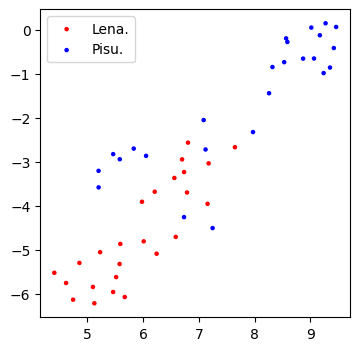

In [6]:
GW_dist_mat = compute_in_parallel(proteins=base_prots, returning= True, comparison_method= GW_protein.run_GW)

We can downsample to an evenly spaced subset of the residues. This significantly improves the runtime but comes at the expense of accuracy. A higher downsampling rate is faster but generally is less accurate.

run time = 0 min, 30 sec
Silhouette Score: 0.12225568220905547
Davies-Bouldin Score: 2.0897725025381066


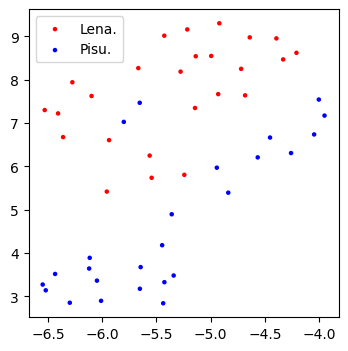

In [8]:
downsampled_100_prots = [p.downsample_n(n=100) for p in base_prots]
compute_in_parallel(proteins=downsampled_100_prots, comparison_method= GW_protein.run_GW)

We can also rescale the intra-protein distance matrices, where computing GW distances gives greater weight to local distances. This generally improves accuracy with minimal effect on runtime.

run time = 7 min, 36 sec
Silhouette Score: 0.14603718508188573
Davies-Bouldin Score: 1.8802514865060744


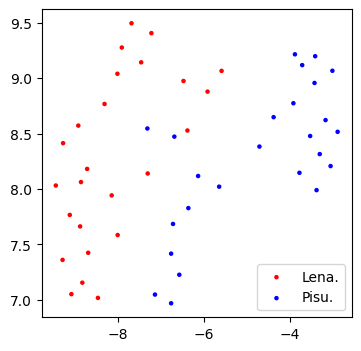

array([[0.        , 0.23889857, 0.2261385 , ..., 0.3861402 , 0.25946949,
        0.3651169 ],
       [0.23889857, 0.        , 0.21583184, ..., 0.29943112, 0.24855051,
        0.32303065],
       [0.2261385 , 0.21583184, 0.        , ..., 0.32754094, 0.27984979,
        0.32353431],
       ...,
       [0.3861402 , 0.29943112, 0.32754094, ..., 0.        , 0.31580879,
        0.33806336],
       [0.25946949, 0.24855051, 0.27984979, ..., 0.31580879, 0.        ,
        0.33370766],
       [0.3651169 , 0.32303065, 0.32353431, ..., 0.33806336, 0.33370766,
        0.        ]])

In [9]:
scaled_prots = [p.scale_ipdm(inplace = False) for p in base_prots]
compute_in_parallel(proteins=scaled_prots, returning= True, comparison_method= GW_protein.run_GW)

We can also combine downsampling with scaling and we check that the order does not matter:

In [10]:
downsampled_then_scaled_prots = [p.scale_ipdm(inplace = False) for p in downsampled_100_prots]
scaled_then_downsampled_prots = [p.downsample_n(n=100) for p in scaled_prots]
assert downsampled_then_scaled_prots == scaled_then_downsampled_prots

run time = 0 min, 35 sec
Silhouette Score: 0.12478009274520394
Davies-Bouldin Score: 1.8948958440721715


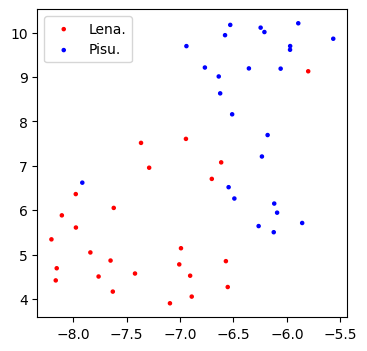

In [11]:
compute_in_parallel(proteins=downsampled_then_scaled_prots, comparison_method= GW_protein.run_GW)

Next we confirm that this agrees with running GW directly from CAJAL cell objects. In this case the CAJAL cells are initialized once at the start as opposed to for reinitialization for each pairwise computation so is slightly faster, especially on larger datasets.

run time = 7 min, 9 sec
Silhouette Score: 0.14924461188337523
Davies-Bouldin Score: 1.9348074777548403


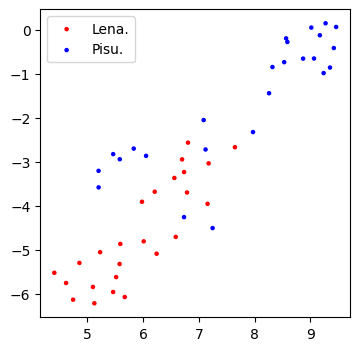

In [12]:
cajal_cells = [p.make_cajal_cell() for p in base_prots]
GW_cajal_dist_mat = compute_in_parallel(cajal_cells, GW_protein.run_GW_from_cajal, returning =True)
assert np.isclose(GW_cajal_dist_mat, GW_dist_mat).all()


Next we demonstrate how to use fused GW with difference based on a BLOSUM matrix. FGW has the potential to improve accuracy but depends on the data used. It generally has a similar runtime as basic GW. 

In [13]:
import GWProt.FGW_matrices

run time = 6 min, 54 sec
Silhouette Score: 0.12018450981396031
Davies-Bouldin Score: 2.0649286216184737


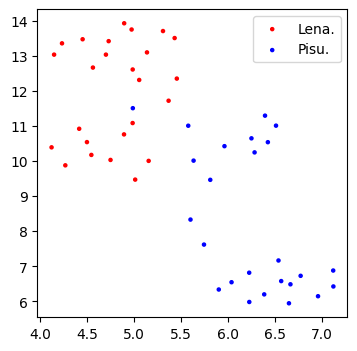

In [15]:
from GWProt.FGW_matrices import *

compute_in_parallel(proteins=base_prots, comparison_method=GW_protein.run_FGW_dict, alpha = 0.05,d = get_BLOSUM_dict(n = 62))

We also demonstrate using user-inputted data. We use eccentricity as a toy example though we do not expect it to improve accuracy.

In [16]:
eccentricity_lists = [p.get_eccentricity() for p in base_prots]
FGW_eccentricity_dist_mat = np.zeros((50,50))

start_time = time.time()
with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein.run_FGW_data_lists(base_prots[pair[0]], 
                                                                                 base_prots[pair[1]], 
                                                                                 data1 = eccentricity_lists[pair[0]],
                                                                                data2 = eccentricity_lists[pair[1]],
                                                                                      alpha = 0.05)), it.combinations(range(50),2))
    for r in results:
        i,j,d = r
        FGW_eccentricity_dist_mat[i,j] = d
        FGW_eccentricity_dist_mat[j,i] = d
run_time = int(time.time() - start_time)
print(f'run time = {run_time//60} min, {run_time % 60} sec')

run time = 4 min, 33 sec


Silhouette Score: 0.1326831398615148
Davies-Bouldin Score: 1.9138791051968063


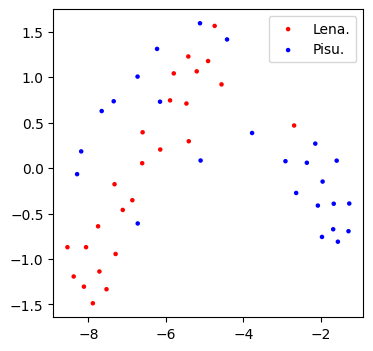

In [17]:
display(FGW_eccentricity_dist_mat)

Now we show the functionality of ``GW_protein_pI`` which runs fused GW with isoelectric points.

In [11]:
base_prots_pI = [GW_protein_pI.make_protein_from_pdb(file) for file in  lenas + pisus]

We check that after casting to ``GW_protein`` s they agree with the earlier ones.

In [19]:
assert base_prots == [p.GW_protein() for p in base_prots_pI]

run time = 8 min, 18 sec
Silhouette Score: 0.12541848315350582
Davies-Bouldin Score: 2.024924386451408


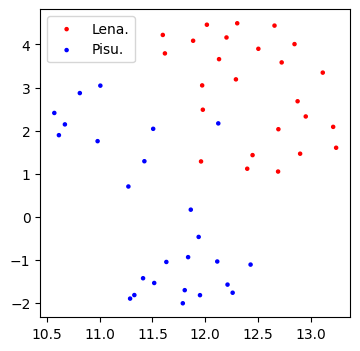

In [20]:
compute_in_parallel(proteins=base_prots_pI, comparison_method= GW_protein_pI.run_FGW, alpha = 0.05)

We see that we can run the same variants as with GW, including uniformly downsampled and with distortion scaling.

run time = 0 min, 49 sec
Silhouette Score: 0.11640165484039261
Davies-Bouldin Score: 2.1235868953498516


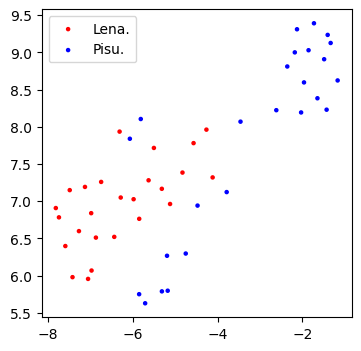

In [21]:
downsampled_100_prots_pI = [p.downsample_n(n=100) for p in base_prots_pI]
compute_in_parallel(proteins=downsampled_100_prots_pI, comparison_method= GW_protein_pI.run_FGW)

run time = 8 min, 7 sec
Silhouette Score: 0.14445442991460322
Davies-Bouldin Score: 1.9530692144369741


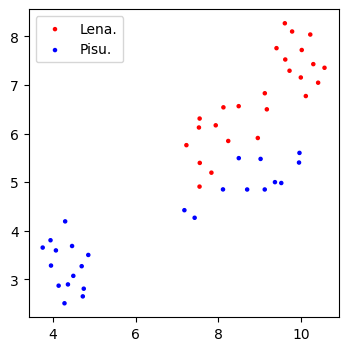

array([[0.        , 1.96370702, 1.8639473 , ..., 3.26430979, 2.16288706,
        2.94059876],
       [1.96370702, 0.        , 1.71818831, ..., 2.39737672, 1.91588255,
        2.56596644],
       [1.8639473 , 1.71818831, 0.        , ..., 2.60025748, 2.2450328 ,
        2.59632148],
       ...,
       [3.26430979, 2.39737672, 2.60025748, ..., 0.        , 2.63495098,
        2.84310265],
       [2.16288706, 1.91588255, 2.2450328 , ..., 2.63495098, 0.        ,
        2.49504326],
       [2.94059876, 2.56596644, 2.59632148, ..., 2.84310265, 2.49504326,
        0.        ]])

In [22]:
scaled_prots_pI = [p.scale_ipdm(inplace = False) for p in base_prots_pI]
compute_in_parallel(proteins=scaled_prots_pI, returning= True, comparison_method= GW_protein_pI.run_FGW)

Finally we demonstrate running FGW with sequence-based downsampling. We first need to run ``convolve_pIs`` to ' smooth ' out the isoelectric point values before the downsampling takes place.

In [12]:
convolved_prots = [p.convolve_pIs(inplace = False) for p in base_prots_pI]


run time = 6 min, 11 sec
Silhouette Score: 0.12118864857501459
Davies-Bouldin Score: 1.9766116796978284


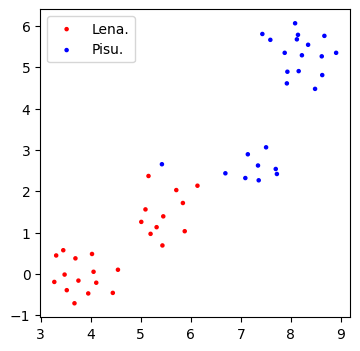

In [13]:
compute_in_parallel(proteins=convolved_prots, comparison_method= GW_protein_pI.run_FGW_seq_aln, alpha = 0.05)